In [1]:
import sys
import ast
print(sys.executable)
import os
import random
import networkx as nx
from matplotlib import pyplot as plt
import pylab
import re
import torch
import numpy as np
import pandas as pd
# 1.nr 2.nid 3.er 4.eid

/usr/bin/python3


In [ ]:
!wget https://github.com/519045752/TagSim/raw/master/IMDB.zip
!unzip /content/IMDB.zip

In [3]:
DATASET = "IMDB"
ORI_DIR = "/content/original"
GEN_DIR ="/content/generated"
TEST_DIR = "/content/test"
TEST_GEN_DIR = "/content/test_gen"
DATASET_FOLDER = "/content"

In [4]:
# test_csv = pd.DataFrame(test_data, columns=['G1', 'G2', 'gt_ged']).to_csv(DATASET_FOLDER + "/testing_pairs.csv",
#                                                                           index=False)
def load_pairs():
    train_pairs = []
    train_csv = pd.read_csv(DATASET_FOLDER+"/training_pairs.csv")
    for index, row in train_csv.iterrows():
        file1 = row['G1']
        file2 = row['G2']
        ged =ast.literal_eval(row['GED'])
        new_ged = [ged[1],ged[3]]
        gt_ged = row['gt_ged']
        graph1 = nx.read_gexf(path=ORI_DIR + '/' + file1)
        graph2 = nx.read_gexf(path=GEN_DIR + '/' + file2)
        train_pairs.append({"graph_pair": [graph1, graph2], "ged": new_ged, "gt_ged":gt_ged})


    test_pairs = []
    test_csv = pd.read_csv(DATASET_FOLDER+"/testing_pairs.csv")
    for index, row in test_csv.iterrows():
        file1 = row['G1']
        file2 = row['G2']
        gt_ged = row['gt_ged']
        if gt_ged<=10:
          graph1 = nx.read_gexf(path=TEST_DIR + '/' + file1)
          graph2 = nx.read_gexf(path=TEST_DIR + '/' + file2)
          test_pairs.append({"graph_pair": [graph1, graph2], "gt_ged": gt_ged})
        else:
          continue
        
    return train_pairs, test_pairs
train_pairs, test_pairs = load_pairs()
print(len(train_pairs))
print(train_pairs[0])
print(len(test_pairs))
print(test_pairs[0])

1200
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7f90c7271090>, <networkx.classes.graph.Graph object at 0x7f90c7271190>], 'ged': [5, 3], 'gt_ged': 8}
42
{'graph_pair': [<networkx.classes.graph.Graph object at 0x7f90c29eac10>, <networkx.classes.graph.Graph object at 0x7f90c293f790>], 'gt_ged': 0.0}


In [5]:
def getFileInfo(filename):
    # if test is False:
    #     g = nx.read_gexf(path="./dataset/"+datasetName+ + filename)
    # else:
    # draw(g)
    reg = re.sub(".*NR_(?P<nr>\d+)_NID_(?P<nid>\d+)_ER_(?P<er>\d+)_EID_(?P<eid>\d+).gexf", "\g<eid>", filename)
    ori = re.sub("(?P<t>.+?)_.*", "\g<t>", filename)
    nr = int(re.sub(".*NR_(?P<t>.+?)_.*", "\g<t>", filename))
    nid = int(re.sub(".*NID_(?P<t>.+?)_.*", "\g<t>", filename))
    er = int(re.sub(".*ER_(?P<t>.+?)_.*", "\g<t>", filename))
    eid = int(re.sub(".*EID_(?P<t>.+?).gexf", "\g<t>", filename))
    gev = nr + nid + er + eid
    # return [ori+'.gexf',str(nr)+str(nid)+str(er)+str(eid)]
    return [ori + '.gexf', [nr, nid, er, eid]]
    # print('ori',ori, 'nr',nr, 'nid',nid, 'er',er, 'eid',eid,'gev',gev)


ori, ged = getFileInfo("4_NR_0_NID_4_ER_2_EID_5.gexf")
print(ori, ged)
print(sum(ged))

4.gexf [0, 4, 2, 5]
11


#Baseline Model


-------Model training---------.

Iteration 0 loss:  0.10584510117769241
Iteration 1 loss:  0.10122551769018173
Iteration 2 loss:  0.09418011456727982
Iteration 3 loss:  0.09113694727420807
Iteration 4 loss:  0.09046852588653564
Iteration 5 loss:  0.08550379425287247
Iteration 6 loss:  0.07409097254276276
Iteration 7 loss:  0.07457204908132553
Iteration 8 loss:  0.07363133132457733
Iteration 9 loss:  0.06865322093168895
Iteration 10 loss:  0.06545168161392212
Iteration 11 loss:  0.06533654034137726
Iteration 12 loss:  0.057550087571144104
Iteration 13 loss:  0.057598259299993515
Iteration 14 loss:  0.05933104455471039
Iteration 15 loss:  0.048662979155778885
Iteration 16 loss:  0.057799357920885086
Iteration 17 loss:  0.05032971128821373
Iteration 18 loss:  0.05248874053359032
Iteration 19 loss:  0.04118374238411585
Iteration 20 loss:  0.04735653102397919
Iteration 21 loss:  0.043620217591524124
Iteration 22 loss:  0.04195962846279144
Iteration 23 loss:  0.04200631380081177
Iteration 2

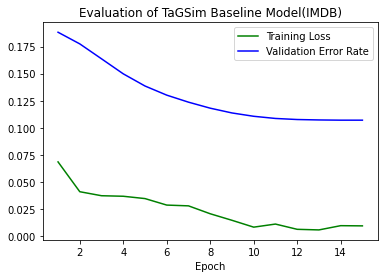


-------Model testing---------.


Model test error: 0.10699650447661822


In [13]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if(graph1_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if(graph2_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)# default: sum
      graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
      graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)


      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_in, score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
test_scores = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Baseline Model(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

#Model without NID


-------Model training---------.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:285: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration 0 loss:  0.09362877160310745
Iteration 1 loss:  0.09200306236743927
Iteration 2 loss:  0.08999495208263397
Iteration 3 loss:  0.07877541333436966
Iteration 4 loss:  0.08105792850255966
Iteration 5 loss:  0.06545659899711609
Iteration 6 loss:  0.06543419510126114
Iteration 7 loss:  0.06413264572620392
Iteration 8 loss:  0.0568266436457634
Iteration 9 loss:  0.0568298747142156
Iteration 10 loss:  0.055316340178251266
Iteration 11 loss:  0.05032862722873688
Iteration 12 loss:  0.047109439969062805
Iteration 13 loss:  0.04392986744642258
Iteration 14 loss:  0.040430739521980286
Iteration 15 loss:  0.0398235060274601
Iteration 16 loss:  0.03356681391596794
Iteration 17 loss:  0.0388917401432991
Iteration 18 loss:  0.03931320831179619
Iteration 19 loss:  0.036818126837412514
Iteration 20 loss:  0.033288031816482544
Iteration 21 loss:  0.032107364386320114
Iteration 22 loss:  0.03695337474346161
Iteration 23 loss:  0.03136807680130005
Iteration 24 loss:  0.03390266373753548
Iteratio

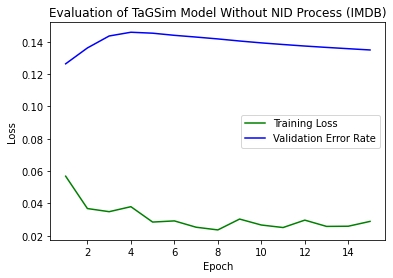


-------Model testing---------.


Model test error: 0.12392668945470914


In [15]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        # self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        # self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_in = torch.nn.Linear(8, 4)
        # self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if(graph1_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if(graph2_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)# default: sum
      graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
      graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)


      # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      # scores_in = torch.t(scores_in)

      # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
test_scores = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test, 'b', label='Validation Error Rate')
plt.title("Evaluation of TaGSim Model Without NID Process (" + DATASET + ')')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

#MAX Pooling


-------Model training---------.

Iteration 0 loss:  0.13056574761867523
Iteration 1 loss:  0.12910297513008118
Iteration 2 loss:  0.13118398189544678
Iteration 3 loss:  0.12206298112869263
Iteration 4 loss:  0.126694917678833
Iteration 5 loss:  0.1271357238292694
Iteration 6 loss:  0.12729020416736603
Iteration 7 loss:  0.1221085786819458
Iteration 8 loss:  0.12351147830486298
Iteration 9 loss:  0.11473600069681804
Iteration 10 loss:  0.11593180149793625
Iteration 11 loss:  0.11851177364587784
Iteration 12 loss:  0.1191849410533905
Iteration 13 loss:  0.11200466006994247
Iteration 14 loss:  0.10939816385507584
Iteration 15 loss:  0.11358584463596344
Iteration 16 loss:  0.11910440772771835
Iteration 17 loss:  0.12136530131101608
Iteration 18 loss:  0.10541262477636337
Iteration 19 loss:  0.11650624871253967
Iteration 20 loss:  0.10875150561332703
Iteration 21 loss:  0.10631854087114334
Iteration 22 loss:  0.10657450556755066
Iteration 23 loss:  0.10490138828754425
Iteration 24 loss:  0

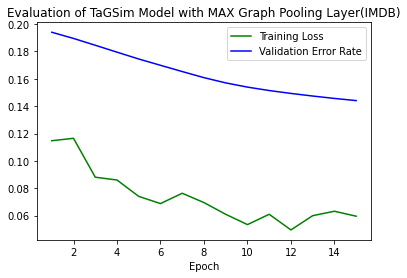


-------Model testing---------.


Model test error: 0.1218912236749713


In [18]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if graph1_hidden1[i][0] >= 10:# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if graph1_hidden2[i][0] >= 50:# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if graph2_hidden1[i][0] >= 10:# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if graph2_hidden2[i][0] >= 50:# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled, max_index01 = torch.max(graph1_01concat, 0)
      graph2_01pooled, max_index02 = torch.max(graph2_01concat, 0)
      graph1_12pooled, max_index12 = torch.max(graph1_12concat, 0)
      graph2_12pooled, max_index22 = torch.max(graph2_12concat, 0)

      graph1_01pooled = torch.unsqueeze(graph1_01pooled, 1)
      graph2_01pooled = torch.unsqueeze(graph2_01pooled, 1)
      graph1_12pooled = torch.unsqueeze(graph1_12pooled, 1)
      graph2_12pooled = torch.unsqueeze(graph2_12pooled, 1)

      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_in, score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train_max = []
test_scores = []
visual_loss_test_max = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train_max.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test_max.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train_max, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test_max, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MAX Graph Pooling Layer(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

#MIN Pooling


-------Model training---------.

Iteration 0 loss:  0.06586949527263641
Iteration 1 loss:  0.06011459603905678
Iteration 2 loss:  0.06412617117166519
Iteration 3 loss:  0.06472679227590561
Iteration 4 loss:  0.0610353983938694
Iteration 5 loss:  0.064064159989357
Iteration 6 loss:  0.06062083691358566
Iteration 7 loss:  0.06298492103815079
Iteration 8 loss:  0.06189529597759247
Iteration 9 loss:  0.05869424839814504
Iteration 10 loss:  0.058082424104213715
Iteration 11 loss:  0.06279634684324265
Iteration 12 loss:  0.06504859030246735
Iteration 13 loss:  0.06045251339673996
Iteration 14 loss:  0.05809679254889488
Iteration 15 loss:  0.061004482209682465
Iteration 16 loss:  0.056565191596746445
Iteration 17 loss:  0.05759045109152794
Iteration 18 loss:  0.0591391883790493
Iteration 19 loss:  0.06419673562049866
Iteration 20 loss:  0.05771962180733681
Iteration 21 loss:  0.06548992544412613
Iteration 22 loss:  0.06420611590147018
Iteration 23 loss:  0.055896468460559845
Iteration 24 los

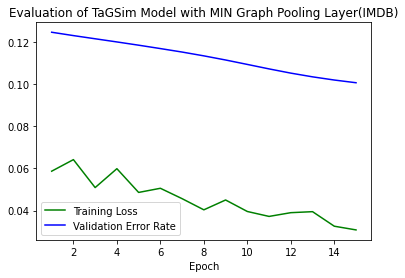


-------Model testing---------.


Model test error: 0.08268983359136785


In [19]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if(graph1_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if(graph2_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled, min_idxs = torch.min(graph1_01concat, 0)
      graph2_01pooled, min_idxs = torch.min(graph2_01concat, 0)
      graph1_12pooled, min_idxs = torch.min(graph1_12concat, 0)
      graph2_12pooled, min_idxs = torch.min(graph2_12concat, 0)

      graph1_01pooled = torch.unsqueeze(graph1_01pooled, 1)
      graph2_01pooled = torch.unsqueeze(graph2_01pooled, 1)
      graph1_12pooled = torch.unsqueeze(graph1_12pooled, 1)
      graph2_12pooled = torch.unsqueeze(graph2_12pooled, 1)

      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_in, score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train_min = []
test_scores = []
visual_loss_test_min = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train_min.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test_min.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train_min, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test_min, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MIN Graph Pooling Layer(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

#MEAN Pooling


-------Model training---------.

Iteration 0 loss:  0.10992664843797684
Iteration 1 loss:  0.11048053950071335
Iteration 2 loss:  0.11060250550508499
Iteration 3 loss:  0.10917936265468597
Iteration 4 loss:  0.11218085139989853
Iteration 5 loss:  0.11528269201517105
Iteration 6 loss:  0.1073727235198021
Iteration 7 loss:  0.10822618007659912
Iteration 8 loss:  0.11285783350467682
Iteration 9 loss:  0.10980114340782166
Iteration 10 loss:  0.1153203621506691
Iteration 11 loss:  0.10208579152822495
Iteration 12 loss:  0.10669734328985214
Iteration 13 loss:  0.10494937002658844
Iteration 14 loss:  0.10396477580070496
Iteration 15 loss:  0.10989484190940857
Iteration 16 loss:  0.10165795683860779
Iteration 17 loss:  0.10849305987358093
Iteration 18 loss:  0.10793093591928482
Iteration 19 loss:  0.09634642799695332
Iteration 20 loss:  0.10090021044015884
Iteration 21 loss:  0.10298674553632736
Iteration 22 loss:  0.0949045866727829
Iteration 23 loss:  0.11109145730733871
Iteration 24 loss: 

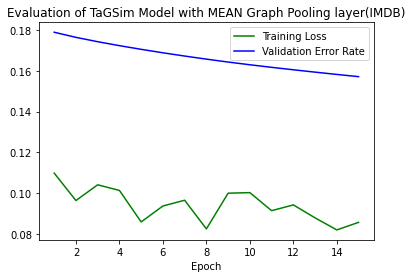


-------Model testing---------.


Model test error: 0.14190642714325327


In [22]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if(graph1_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if(graph2_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.mean(graph1_01concat, 0)
      graph2_01pooled = torch.mean(graph2_01concat, 0)
      graph1_12pooled = torch.mean(graph1_12concat, 0)
      graph2_12pooled = torch.mean(graph2_12concat, 0)

      graph1_01pooled = torch.unsqueeze(graph1_01pooled, 1)
      graph2_01pooled = torch.unsqueeze(graph2_01pooled, 1)
      graph1_12pooled = torch.unsqueeze(graph1_12pooled, 1)
      graph2_12pooled = torch.unsqueeze(graph2_12pooled, 1)

      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_in, score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train_mean = []
test_scores = []
visual_loss_test_mean = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train_mean.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test_mean.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train_mean, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test_mean, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with MEAN Graph Pooling layer(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

#SUM Pooling


-------Model training---------.

Iteration 0 loss:  0.09598007053136826
Iteration 1 loss:  0.10103020071983337
Iteration 2 loss:  0.09973186999559402
Iteration 3 loss:  0.09187352657318115
Iteration 4 loss:  0.08611701428890228
Iteration 5 loss:  0.08218779414892197
Iteration 6 loss:  0.08649326115846634
Iteration 7 loss:  0.07940390706062317
Iteration 8 loss:  0.07189919799566269
Iteration 9 loss:  0.07921514411767323
Iteration 10 loss:  0.07790276408195496
Iteration 11 loss:  0.07256216555833817
Iteration 12 loss:  0.0682750791311264
Iteration 13 loss:  0.07501459866762161
Iteration 14 loss:  0.07067687809467316
Iteration 15 loss:  0.07530438899993896
Iteration 16 loss:  0.06987958401441574
Iteration 17 loss:  0.0684688463807106
Iteration 18 loss:  0.07404391467571259
Iteration 19 loss:  0.07398270070552826
Iteration 20 loss:  0.07514255493879318
Iteration 21 loss:  0.06900317966938019
Iteration 22 loss:  0.07529500871896744
Iteration 23 loss:  0.07327581197023392
Iteration 24 loss:

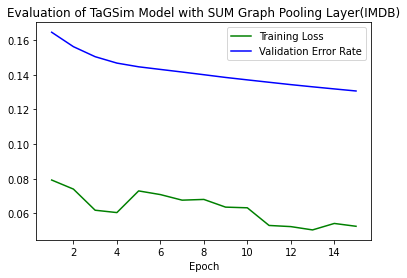


-------Model testing---------.


Model test error: 0.1138482002244841


In [21]:
import torch
import numpy as np


class TensorNetworkModule(torch.nn.Module):
    def __init__(self, tensor_neurons, input_dim):
        super(TensorNetworkModule, self).__init__()
        self.input_dim = input_dim
        self.tensor_neurons = tensor_neurons
        self.setup_weights()
        self.init_parameters()

    def setup_weights(self):
        self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
        self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2 * self.input_dim))
        self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

    def init_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_matrix)
        torch.nn.init.xavier_uniform_(self.weight_matrix_block)
        torch.nn.init.xavier_uniform_(self.bias)

    def forward(self, embedding_1, embedding_2):
        scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
        scoring = scoring.view(self.input_dim, self.tensor_neurons)
        scoring = torch.mm(torch.t(scoring), embedding_2)
        combined_representation = torch.cat((embedding_1, embedding_2))
        block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
        scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
        return scores


def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result


class TaGSim(torch.nn.Module):
    def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
        super(TaGSim, self).__init__()
        # self.number_of_node_labels = len(number_of_node_labels)
        # self.number_of_edge_labels = len(number_of_edge_labels)
        self.tensor_neurons = tensor_neurons
        self.bottle_neck_neurons = bottle_neck_neurons
        self.setup_layers()

    def setup_layers(self):
        self.feature_count = self.tensor_neurons

        # self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 11)
        # self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2 * self.number_of_node_labels)
        self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 60)

        # self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_nc = torch.nn.Linear(8, 4)
        # self.scoring_layer_nc = torch.nn.Linear(4, 1)

        self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_in = torch.nn.Linear(8, 4)
        self.scoring_layer_in = torch.nn.Linear(4, 1)

        # self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        # self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
        # self.fully_connected_third_ie = torch.nn.Linear(8, 4)
        # self.scoring_layer_ie = torch.nn.Linear(4, 1)

        self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
        self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
        self.fully_connected_third_ec = torch.nn.Linear(8, 4)
        self.scoring_layer_ec = torch.nn.Linear(4, 1)

    def gal_pass(self, edge_index, features):
        hidden1 = graph_aggregation_layer(features, edge_index)
        hidden2 = graph_aggregation_layer(hidden1, edge_index)
        return hidden1, hidden2

    def forward(self, label_multiset):
      adj_1 = torch.FloatTensor(np.array(label_multiset["edge_index_1"].todense()))
      adj_2 = torch.FloatTensor(np.array(label_multiset["edge_index_2"].todense()))
      features_1, features_2 = label_multiset["features_1"], label_multiset["features_2"]
      
      graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, features_1)#
      graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, features_2)#
    
      Graph1_hidden1, Graph1_hidden2, Graph2_hidden1, Graph2_hidden2 = [], [], [], []
      for i in range(graph1_hidden1.size()[0]):
        if(graph1_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
            Graph1_hidden1.append([0.0]*9 + [1.0])
        else:
            Graph1_hidden1.append([1.0 if graph1_hidden1[i][0] == j else 0.0 for j in range(10)])

        if(graph1_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
            Graph1_hidden2.append([0.0]*49 + [1.0])
        else:
            Graph1_hidden2.append([1.0 if graph1_hidden2[i][0] == j else 0.0 for j in range(50)])

      for i in range(graph2_hidden1.size()[0]):
          if(graph2_hidden1[i][0] >= 10):# 10 for imdb; 6 for linux # the valus here can be set by the users
              Graph2_hidden1.append([0.0]*9 + [1.0])
          else:
              Graph2_hidden1.append([1.0 if graph2_hidden1[i][0] == j else 0.0 for j in range(10)])

          if(graph2_hidden2[i][0] >= 50):# 50 for imdb; 15 for linux # the valus here can be set by the users
              Graph2_hidden2.append([0.0]*49 + [1.0])
          else:
              Graph2_hidden2.append([1.0 if graph2_hidden2[i][0] == j else 0.0 for j in range(50)])
      Graph1_hidden1, Graph1_hidden2 = torch.FloatTensor(np.array(Graph1_hidden1)), torch.FloatTensor(np.array(Graph1_hidden2))
      Graph2_hidden1, Graph2_hidden2 = torch.FloatTensor(np.array(Graph2_hidden1)), torch.FloatTensor(np.array(Graph2_hidden2))

      graph1_01concat = torch.cat([features_1, Graph1_hidden1], dim=1)
      graph2_01concat = torch.cat([features_2, Graph2_hidden1], dim=1)
      graph1_12concat = torch.cat([Graph1_hidden1, Graph1_hidden2], dim=1)
      graph2_12concat = torch.cat([Graph2_hidden1, Graph2_hidden2], dim=1)

      graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)# default: sum
      graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
      graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
      graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)


      scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
      scores_in = torch.t(scores_in)

      scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
      scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
      score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

      scores_ec = self.tensor_network_ec(graph1_12pooled, graph2_12pooled)
      scores_ec = torch.t(scores_ec)

      scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
      scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
      score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

      return torch.cat([score_in, score_ec], dim=1)
        # adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(
        #     np.array(label_multiset["node_index_2"].todense()))
        # edge_adj_1, edge_adj_2 = label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
        # node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
        # edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

        # #gal
        # graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)  #original graph node
        # graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)  #generated graph node
        # edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)  #original edge node
        # edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)  #generated graph edge
        # #node level embedding Concatenation
        # graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
        # graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
        # graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
        # graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
        # #graph pooling: node Sum
        # graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
        # graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
        # graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
        # graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
        # #edge level embedding Concatenation
        # edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
        # edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
        # #graph pooling: edge Sum
        # edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
        # edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

        # # scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
        # # scores_nc = torch.t(scores_nc)
        # #
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
        # # scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
        # # score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

        # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
        # scores_in = torch.t(scores_in)

        # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
        # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
        # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

        # # scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
        # # scores_ie = torch.t(scores_ie)
        # #
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
        # # scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
        # # score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

        # scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
        # scores_ec = torch.t(scores_ec)

        # scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
        # scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
        # score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

        # return torch.cat([ score_in,  score_ec], dim=1)

    def transform_label_multiset(self, graph_pair, type_specified=True):
        graph1 = graph_pair['graph_pair'][0]
        graph2 = graph_pair['graph_pair'][1]
        ged = graph_pair['ged']

        label_multiset = dict()
        node_features_1, node_features_2= [], []

        for i in graph1.nodes():
            node_features_1.append([1.0])
        for i in graph2.nodes():
            node_features_2.append([1.0])

        node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(
            np.array(node_features_2))

        label_multiset["edge_index_1"], label_multiset["edge_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
        label_multiset["features_1"], label_multiset["features_2"] = node_features_1, node_features_2

        # label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(
        #     graph1), nx.adjacency_matrix(graph2)
        # label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
        # label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
        # label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

        #ged normalisation
        if (type_specified):  # for training
            avg_node_number = 0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())
            norm_ged = [n / avg_node_number for n in ged]
            norm_ged = np.array(norm_ged)
            label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1, -1).float()

            norm_gt_ged = (sum(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
        else:  # for testing
            norm_gt_ged = (ged) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
            label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

        return label_multiset


import matplotlib.pyplot as plt

epochs = 15
tensor_neurons = 4
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.2
lr = 0.001
weight_decay = 0.0

Node_Types = ['1']
Edge_Types = ['1']
#collection global node label and edge label info

print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train_sum = []
test_scores = []
visual_loss_test_sum = []
train_pair = []
test_pair = []
epo = []

#model training
for epoch in range(epochs):
    random.shuffle(train_pairs)
    batches = []
    for graph in range(0, len(train_pairs), batch_size):
        batches.append(train_pairs[graph:graph + batch_size])

    for batch in batches:
        model.train()
        optimizer.zero_grad()
        losses = 0
        for graph_pair in batch:
            data = model.transform_label_multiset(graph_pair)
            prediction = model(data)
            losses += torch.nn.functional.mse_loss(data["target"], prediction)

        losses.backward(retain_graph=True)
        optimizer.step()
        loss = losses.item()
        print('Iteration', iteration, 'loss: ', loss / len(batch))
        iteration += 1

    visual_loss_train_sum.append(loss / len(batch))
    # testing
    model.eval()
    for n in test_pairs:
        graph1 = n['graph_pair'][0]  #updated_test
        graph2 = n['graph_pair'][1]  #updated_test
        ged = int(n['gt_ged'])
        tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
        data = model.transform_label_multiset(tem_data, type_specified=False)
        prediction = model(data)
        prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
        current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
        test_scores.append(current_error.data.item())
    visual_loss_test_sum.append(sum(test_scores) / len(test_scores))
    epo.append(epoch + 1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train_sum, 'g', label='Training Loss')
plt.plot(epo, visual_loss_test_sum, 'b', label='Validation Error Rate')
plt.title('Evaluation of TaGSim Model with SUM Graph Pooling Layer(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n-------Model testing---------.\n")

model.eval()
test_scores = []
for n in test_pairs:
    graph1 = n['graph_pair'][0]  #updated_test
    graph2 = n['graph_pair'][1]  #updated_test
    ged = int(n['gt_ged'])
    tem_data = {"graph_pair": [graph1, graph2], "ged": ged}
    data = model.transform_label_multiset(tem_data, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))

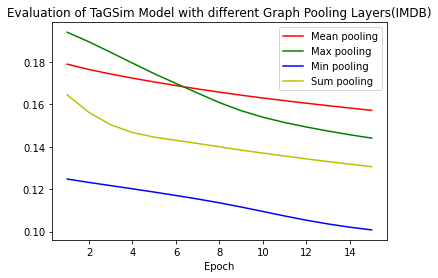

In [26]:
plt.plot(epo, visual_loss_test_mean, 'r', label='Mean pooling')
plt.plot(epo, visual_loss_test_max, 'g', label='Max pooling')
plt.plot(epo, visual_loss_test_min, 'b', label='Min pooling')
plt.plot(epo, visual_loss_test_sum, 'y', label='Sum pooling')
plt.title('Evaluation of TaGSim Model with different Graph Pooling Layers(' + DATASET + ')')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()
plt.show()